In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.5


## Function definitions

In [2]:
def plot_hist(x, f, bins=30, xlim=100, neglim=0):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_xlim(neglim, xlim)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

In [3]:
def summary_stats(x, f, low, high):
    avg = np.mean(x)
    dev = np.std(x)
    low_thresh = np.percentile(x, low)
    high_thresh = np.percentile(x, high)
    print("Given %d variants, we have the following stats for %s:\nMean: %f\
            \nSt. Deviation: %f\n%dth percentile: %f\n%dth percentile: %f\n"
          % (len(x), f, avg, dev, low, low_thresh, high, high_thresh))

## morex-sample2 exploration

In [5]:
# Unfiltered VCF
#fp = "/panfs/roc/groups/9/morrellp/shared/Projects/Mutant_Barley/longranger_morex_v2/morex-sample2/morex-sample2_concat_sorted.vcf"
# After filtering using 10x Genomics tuned filters
vcf_fp = "/panfs/roc/groups/9/morrellp/shared/Projects/Mutant_Barley/longranger_morex_v2/morex-sample2/Filtered/morex-sample2_filtered_pass1.vcf"
h5_fp = "/panfs/roc/groups/9/morrellp/shared/Projects/Mutant_Barley/longranger_morex_v2/morex-sample2/Filtered/morex-sample2_filtered_pass1.h5"

Convert to h5 format if it doesn't exist already by running the following:

```Python
allel.vcf_to_hdf5(vcf_fp, h5_fp, fields='*', overwrite=True)
```

In [6]:
# Convert VCF to h5 format
allel.vcf_to_hdf5(vcf_fp, h5_fp, fields='*', overwrite=True)

In [7]:
# Read in h5 file
callset = h5py.File(h5_fp, mode='r')

In [8]:
callset.keys()

<KeysViewHDF5 ['calldata', 'samples', 'variants']>

In [9]:
# VCF column names and info in INFO field
variants = allel.VariantChunkedTable(callset['variants'],
                                    names=['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'DP', 'MQM', 'MQMR', 'AC'])

In [10]:
variants

<VariantChunkedTable shape=(765595,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('QUAL', '<f4'), ('DP', '<i4'), ('MQM', '<f4', (3,)), ('MQMR', '<f4'), ('AC', '<i4', (3,))]
   nbytes=58.4M cbytes=15.0M cratio=3.9
   values=h5py._hl.group.Group>

### Per sample DP

In [11]:
# Pull per sample DP
per_samp_DP = callset['calldata/DP'][:,:].flatten()

In [12]:
# Number of variants before filtering on DP
summary_stats(per_samp_DP, 'DP', 10, 95)

Given 765595 variants, we have the following stats for DP:
Mean: 45.049309            
St. Deviation: 411.379506
10th percentile: -1.000000
95th percentile: 78.000000



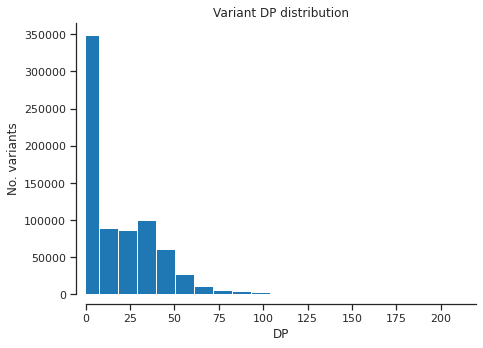

In [13]:
# Per sample DP distribution
plot_hist(per_samp_DP, 'DP', bins=6000, xlim=220)

In [14]:
# Explore DP filters
dp_filt = per_samp_DP[(per_samp_DP > 5) & (per_samp_DP < 78)]
dp_filt

array([13, 28, 34, ...,  7, 23,  7], dtype=int16)

In [15]:
len(dp_filt)

403756

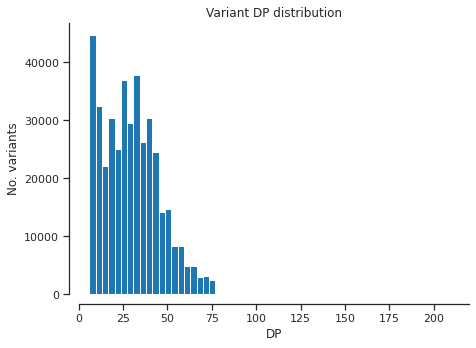

In [16]:
# Plot filtered dataset
plot_hist(dp_filt, 'DP', bins=20, xlim=220)

### QUAL

In [17]:
# Pull QUAL
tmp_qual_var = callset['variants/QUAL'][:].flatten()
# There are nan values present, remove before proceeding
qual_var = tmp_qual_var[np.logical_not(np.isnan(tmp_qual_var))]
qual_var

array([ 21.4882, 107.441 ,  32.5539, ..., 412.458 ,  15.1211, 159.278 ],
      dtype=float32)

In [18]:
# Number of variants before filtering on QUAL
summary_stats(qual_var, 'QUAL', 5, 95)

Given 759086 variants, we have the following stats for QUAL:
Mean: 1126.008423            
St. Deviation: 10477.655273
5th percentile: 24.169200
95th percentile: 1953.022522



We don't need to do an additional filter on QUAL because we have already filtered on the 10x Genomics data tuned QUAL filter. See documentation for more details: https://support.10xgenomics.com/genome-exome/software/pipelines/latest/output/vcf

### Per sample GQ

We can't filter on per sample GQ because the 10x Genomics VCF doesn't have this metric.

In [72]:
callset['calldata/GT']

<HDF5 dataset "GT": shape (819993, 1, 2), type "|i1">